# Assignment 5 - Fraud: A how-to guide
Anna Pauxberger

27 November 2018

# The Model

### Intro
To detect fraud and other abnomalies, it is helpful to create synthetic datasets that model what the data is expected to look like. The below code models 2518 transactions over the span of four years. It models (1) the number of transactions in a single month (2) the day in the month that the transaction occurs (3) transaction size. Using these models, a fake month of transactions is created.

### Density Models
Density models model data by placing Gaussian distributions on each data point. The more data, the smoother the Gaussians can model the space. If there are only few data points, the bandwidth parameter can influence how strongly the few data points influence the model, or how smooth the model will be. The bandwidth is similar to the standard deviation of the Gaussians - the higher it is the more flexibility we allow. 

For example in modeling the day in the month, a bandwidth of 2 would indicate that the Gaussian placed on the training data point, e.g. on day 8, has 95% of its density between day 6 and day 10. If the bandwidth is too low, the model gives too much weight to the training data points, which could overfit the model. However, a large bandwidth may be too inaccurate. 

#overfitting


### Limitations
- Gaussian KDEs are continuous, but our dataset is discrete with transactions happening on a daily basis (e.g. there is no 14.5th of September). 
- The model approximates the data with Gaussian distributions but without limits, which could lead to sampling negative numbers for number of transactions, for example. In the creation of the fictitious month the distribution is "truncated" by not allowing to sample negative numbers for number of transactions and day of month, but this violates the assumption of coming from a Gaussian distribution. 
- The data size is quite small, especially when grouped by month, which makes parameter optimization and cross-validation more difficult. If more data was available, it would be interesting to use for example the last year as test set to also test for time effects.
- The model is also not able to capture the proximit of the first and last day of the month, since we did not specify that e.g. the 1st comes after the 31st, or whether the month ends on the 28th/30th/31st. This impairs the modeling around these values. 
- Finally, other parameters play into whether or not a transaction was fraudulent, such as the time of the day, what location the transaction occurred in, or what purpose the transaction had. A forensic accountant would have good reasons to be skeptical of the below model. 

In [2]:
import pandas as pd
import requests
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import math
import seaborn as sns
from sklearn.neighbors.kde import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut

### Data exploration

In [17]:
url = "https://course-resources.minerva.kgi.edu/uploaded_files/mke/Y5GZpr/anonymized.csv"
fraud = pd.read_csv(url)

In [21]:
fraud['Datetime'] = pd.to_datetime(fraud['Date'])
fraud['Date'] = fraud['Datetime'].dt.strftime('%Y%m%d')

In [239]:
len(fraud), min(fraud['Datetime']), max(fraud['Datetime'])

(2518, Timestamp('2013-09-20 00:00:00'), Timestamp('2017-09-28 00:00:00'))

In [185]:
fraud['year_month'] = fraud['Datetime'].dt.to_period('M')
fraud.head()

,Date,Amount,Datetime,month_year,year_month,day,diff
0,20160525,54241.35,2016-05-25,2016-05,2016-05,25,NaN
1,20170529,54008.83,2017-05-29,2017-05,2017-05,29,0.0
2,20170630,54008.82,2017-06-30,2017-06,2017-06,30,0.0
3,20170105,52704.37,2017-01-05,2017-01,2017-01,5,0.0
4,20170223,52704.36,2017-02-23,2017-02,2017-02,23,0.0


### Optimal Bandwidth Cross-Validation

Since our data size is rather small, I decided to cross-validate my choice of the bandwidth using the leave one out method. The optimal_bandwidth() function computes the log probability of the test set, or to be precise the average probability of a point of the test set being sampled by the model. Since we are dealing with continuous variables and the probability of a continuous variable is always zero, the log probabilities are only relevant in a comparative view.

I decided on the choice of the leave one out method, since we only have 49 datapoints for the estimation of number of transactions per month. As I apply the same method to the subsequent models with 2518 datapoints, LOO might perform a little worse since results might be strongly correlated, but I decided that an optimization of cross-validation methods would go beyond the scope of the assignment. 

In [394]:
def optimal_bandwidth(data, bandwidths):
    '''
    Optimizes the bandwidth smoothing parameter via Leave-One-Out
    cross-validation. Computes the score on test data to get the log 
    probability.
    '''
    loo = LeaveOneOut()
    score_means, score_stds = [], []
    
    for b in bandwidths:
        scores = []
        for train_index, test_index in loo.split(data):
            x_train, X_test = data[train_index], data[test_index]
            train_set = np.asarray(x_train).reshape(-1,1)
            test_set = np.asarray(X_test).reshape(-1,1)

            kde = KernelDensity(kernel='gaussian', bandwidth=b).fit(train_set)
            # kde.score() returns the log likelihood 
            # exponentiated to be better interpretable
            # divided by the length of the test set to get average probability
            
            #scores.append(math.exp(kde.score(test_set)/len(test_set)))
            scores.append(kde.score(test_set))
    
        N = loo.get_n_splits(data)
        score_means.append(np.mean(scores))
        score_stds.append(np.std(scores)/math.sqrt(N))
            
    score_idx = (score_means.index(max(score_means)))
    optimal_b = bandwidths[score_idx]
    
    return optimal_b, bandwidths, score_means, score_stds

### (1) Number of transactions per month

In [263]:
count_per_month = fraud.groupby('year_month').agg(['mean','count'])
count_per_month.shape

(49, 6)

In [264]:
count_per_month.head()

Amount             day       diff      
                   mean count      mean count mean count
year_month                                              
2013-09     1286.093000    10  25.20000    10  0.0    10
2013-10      664.856250    16  17.93750    16  0.0    16
2013-11     1232.373750     8  23.75000     8  0.0     8
2013-12      208.321111    27  18.62963    27  0.0    27
2014-01     -850.503500    40  16.82500    40  0.0    40

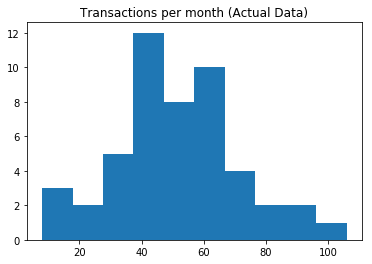

In [326]:
# Actual Data
plt.hist(count_per_month['Amount', 'count'])
plt.title('Transactions per month (Actual Data)')
plt.show()

In [380]:
# Optimal Parameter
# Since we have only 49 datapoints for transaction amounts of approximately 1-110
# I would expect the parameter to be rather large to smooth the data (~5)

bandwidths_1 = [0.01, 0.1, 1, 5, 10, 20, 100]
X_1 = np.asarray(count_per_month['Amount', 'count']).reshape(-1,1)

optimal_outcome_1 = optimal_bandwidth(X_1, bandwidths_1)
optimal_b_1 = optimal_outcome_1[0]
print("Optimal bandwidth:", optimal_b_1)
optimal_outcome_1

Optimal bandwidth: 10


(10,
 [0.01, 0.1, 1, 5, 10, 20, 100],
 [-30101.909769275597,
  -303.19194620533005,
  -7.1442460376575,
  -4.5690775885714485,
  -4.487550088798875,
  -4.532725894191995,
  -5.564507558916142],
 [12319.079553836022,
  123.200859907732,
  1.2593544232607967,
  0.13805710338471258,
  0.10323140130037951,
  0.06136482983501007,
  0.004389673340568858])

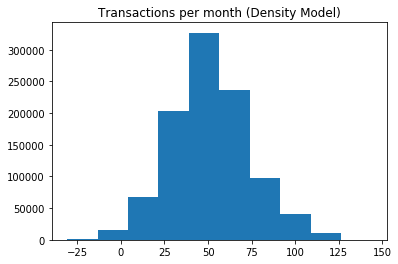

In [370]:
# Density Model
kde_1 = KernelDensity(kernel='gaussian', bandwidth=optimal_b_1).fit(X_1)

samples_1 = kde_1.sample(1000000)
plt.hist(samples_1, bins=10)
plt.title('Transactions per month (Density Model)')
plt.show()

### (2) Day Of The Month

In [378]:
fraud['day'] = fraud['Datetime'].dt.day
fraud['day'].shape

(2518,)

In [376]:
fraud.head()

,Date,Amount,Datetime,month_year,year_month,day,diff
0,20160525,54241.35,2016-05-25,2016-05,2016-05,25,NaN
1,20170529,54008.83,2017-05-29,2017-05,2017-05,29,0.0
2,20170630,54008.82,2017-06-30,2017-06,2017-06,30,0.0
3,20170105,52704.37,2017-01-05,2017-01,2017-01,5,0.0
4,20170223,52704.36,2017-02-23,2017-02,2017-02,23,0.0


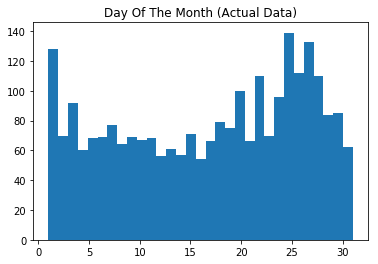

In [392]:
# Actual Data
plt.hist(fraud['day'], bins=31)
plt.title('Day Of The Month (Actual Data)')
plt.show()

In [395]:
# Optimal Parameter
# should be rather small (around 1-2) since we have 2518 data points for 31 days
# Unexpectedly, the optimization leads to a bandwidth close to zero, indicating that the
# model performs almost no smoothing. The histogram of the model looks similar to real data.

bandwidths_2 = [0.00000000001, 0.0001, 0.001, 0.01, 0.1, 1]
X_2 = np.asarray(fraud['day']).reshape(-1,1)

optimal_outcome_2 = optimal_bandwidth(X_2, bandwidths_2)
optimal_b_2 = optimal_outcome_2[0]
print("Optimal bandwidth:", optimal_b_2)
optimal_outcome_2

Optimal bandwidth: 1e-11


(1e-11,
 [1e-11, 0.0001, 0.001, 0.01, 0.1, 1],
 [1376953220.6857276,
  137.69532206857264,
  13.769532206857273,
  1.3769532206857262,
  0.13769532206857266,
  0.03290099777094529],
 [8128367.096078402,
  0.8128367096078387,
  0.08128367096078401,
  0.008128367096078391,
  0.0008128367096078393,
  0.00015758742399238102])

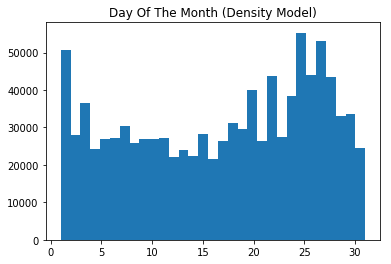

In [393]:
# Density Model
kde_2 = KernelDensity(kernel='gaussian', bandwidth=optimal_b_2).fit(X_2)

samples_2 = kde_2.sample(1000000)
plt.hist(samples_2, bins=31)
plt.title('Day Of The Month (Density Model)')
plt.show()

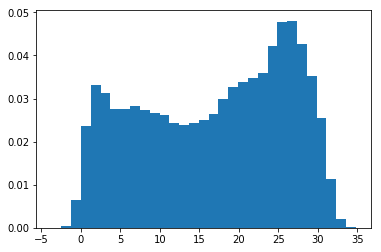

In [158]:
# Neglecting the parameter optimization and choosing a higher bandwidth
# It becomes visible that the smoothing is stronger, at the expense of estimates outside
# the expected range to occur more often as well.

X_2 = np.asarray(fraud['day']).reshape(-1,1)
kde_2 = KernelDensity(kernel='gaussian', bandwidth=1).fit(X_2)

samples_2 = kde_2.sample(1000000)
plt.hist(samples_2, bins=31, density=True)
plt.show()

### (3) Transaction Size

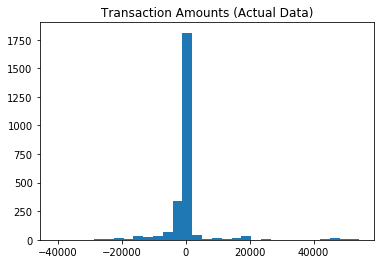

In [335]:
# Actual Data
plt.hist(fraud['Amount'], bins=31)
plt.title('Transaction Amounts (Actual Data)')
plt.show()

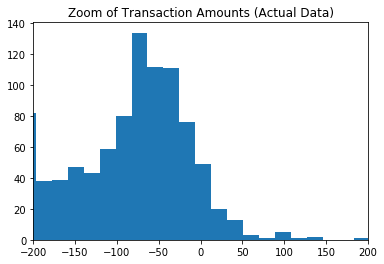

In [337]:
# Real Data
plt.hist(fraud_train['Amount'], bins=5000)
plt.title('Zoom of Transaction Amounts (Actual Data)')
plt.xlim(-200, 200)
plt.show()

In [387]:
# Optimal Parameter
# Hard to estimate, but rather large. We have a lot of data points (2518), but they are 
# concentrated around -1000, whereas there are areas when there are only few data points.

bandwidths_3 = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
X_3 = np.asarray(fraud['Amount']).reshape(-1,1)

optimal_outcome_3 = optimal_bandwidth(X_3, bandwidths_3)
optimal_b_3 = optimal_outcome_3[0]
print("Optimal bandwidth:", optimal_b_3)
optimal_outcome_3

Optimal bandwidth: 1000


(1000,
 [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
 [-17994896179.03721,
  -179948964.7690037,
  -1799494.7784333779,
  -18001.71161429484,
  -187.67143917912716,
  -10.062152561782712,
  -8.986266319704667,
  -10.377596695981277],
 [8791803461.040073,
  87918034.61131996,
  879180.3471360521,
  8791.805019509291,
  87.92072745349394,
  0.8840789868137336,
  0.03483370986333481,
  0.012630422055555085])

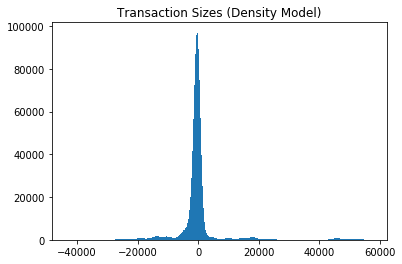

In [388]:
# Density Model
kde_3 = KernelDensity(kernel='gaussian', bandwidth=optimal_b_3).fit(X_3)

samples_3 = kde_3.sample(1000000)
plt.hist(samples_3, bins=300)
plt.title('Transaction Sizes (Density Model)')
plt.show()

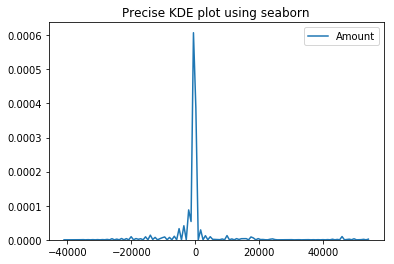

In [375]:
# KDE Plot
sns.kdeplot(fraud['Amount'], bw=0.0000002)
plt.title('Precise KDE plot using seaborn')
plt.show()

### Fictitious month

In [347]:
def keep_if_positive(sampling_method):
    hold = -1
    while hold < 1:
        hold = sampling_method
    return hold

def fake_month():
    # (1) Number of transactions
    nr_of_transactions = int(keep_if_positive(kde_1.sample(1)))
    days, amounts = [], []
    
    # (2) Day of month
    for i in range(nr_of_transactions):
        day_of_month = -1
        while day_of_month < 1 or day_of_month > 31:
            day_of_month = int(kde_2.sample(1)[0,0])
        days.append(day_of_month)
        
        # (3) Transaction amount
        amount = round(kde_3.sample(1)[0,0], 2)
        amounts.append(amount)
        
    return days, amounts

In [348]:
result = fake_month()
d = {'days': result[0], 'amounts': result[1]}
pd.DataFrame(d).sort_values(by='days')

,days,amounts
78,1,857.60
40,1,-1500.00
87,1,23969.65
19,2,-66.00
83,2,-25.98
42,2,-786.41
7,2,-348.00
70,3,-100.00
92,3,-684.25
12,5,-1500.00


### Optional: Benford's Law
As visible in the graph below, the transaction data follows Benford's Law, and we can see that digit 1 occurs about 30% of the time (~35%). 

In [355]:
initial_digits = abs(fraud['Amount']).astype(str).str[0].astype(int)
initial_digits.shape

(2518,)

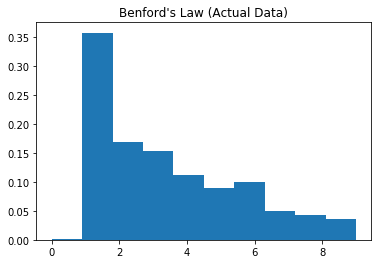

In [359]:
# Actual Data
plt.hist(initial_digits, bins=10, density=True)
plt.title("Benford's Law (Actual Data)")
plt.show()